In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置随机种子以保证结果可复现
np.random.seed(42)

# 1. 生成数据
n_samples = 10000
# 生成协变量
age = np.random.uniform(30, 80, n_samples)
bmi = np.random.normal(28, 4, n_samples)
sex = np.random.binomial(1, 0.5, n_samples)

# 创建特征DataFrame
X = pd.DataFrame({'age': age, 'bmi': bmi, 'sex': sex})

# 2. 定义真实的CATE函数 (在现实中是未知的)
# 假设药物对年龄较大、BMI较高的人效果更好，对女性效果略好
true_cate = (age - 30) / 20 + (bmi - 28) / 5 + sex * 2

# 3. 生成倾向得分，模拟非随机分配
# 假设医生更倾向于给年龄较大、BMI较高的患者开新药
propensity = 1 / (1 + np.exp(-(0.05 * (age - 55) + 0.1 * (bmi - 28))))
treatment = np.random.binomial(1, propensity, n_samples)

# 4. 生成潜在结果
# 基础血压降低值（无药效）
y0 = 5 + 0.1 * (age - 55) - 0.2 * (bmi - 28) + np.random.normal(0, 2, n_samples)
# 有药效的血压降低值
y1 = y0 + true_cate

# 5. 生成观测结果
outcome = np.where(treatment == 1, y1, y0)

print("数据生成完毕！")
print(f"处理组样本数: {np.sum(treatment)}")
print(f"对照组样本数: {n_samples - np.sum(treatment)}")

数据生成完毕！
处理组样本数: 4949
对照组样本数: 5051


In [2]:
outcome

array([ 4.54902094, 14.47736955,  7.73535534, ..., 13.16439495,
        3.99666353,  3.88172667])

In [3]:
from causalml.inference.meta import BaseSLearner, BaseTLearner, BaseXLearner
from causalml.metrics import plot_gain
from sklearn.ensemble import RandomForestRegressor

# CausalML要求将干预变量命名为 'treatment'，结果变量命名为 'outcome'
df = X.copy()
df['treatment'] = treatment
df['outcome'] = outcome

In [4]:
df

,age,bmi,sex,treatment,outcome
0,48.727006,22.048553,0,0,4.549021
1,77.535715,23.499256,0,1,14.477370
2,66.599697,29.555276,0,0,7.735355
3,59.932924,23.304507,0,1,5.939146
4,37.800932,32.450537,1,0,4.815693
...,...,...,...,...,...
9995,72.882799,27.887503,1,0,2.994241
9996,74.875442,31.169580,0,1,10.686892
9997,77.335396,31.978072,1,1,13.164395
9998,49.874400,25.210681,0,1,3.996664


In [5]:
# 1. S-Learner实现
print("\n--- CausalML S-Learner ---")
slearner = BaseSLearner(learner=RandomForestRegressor(n_estimators=100, random_state=42))
# CausalML的 .estimate_ate() 返回 CATE
slearner_cate = slearner.fit_predict(X=X, treatment=treatment, y=outcome)


--- CausalML S-Learner ---


In [6]:
df['slearner_cate_causalml'] = slearner_cate

In [7]:
import warnings
from sklearn.exceptions import ConvergenceWarning

In [8]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [9]:
# 2. T-Learner实现
print("--- CausalML T-Learner ---")
tlearner = BaseTLearner(learner=RandomForestRegressor(n_estimators=100, random_state=42))
tlearner_cate = tlearner.fit_predict(X=X, treatment=treatment, y=outcome)
df['tlearner_cate_causalml'] = tlearner_cate
df

--- CausalML T-Learner ---


,age,bmi,sex,treatment,outcome,slearner_cate_causalml,tlearner_cate_causalml
0,48.727006,22.048553,0,0,4.549021,-0.265474,-0.794183
1,77.535715,23.499256,0,1,14.477370,4.079010,3.716235
2,66.599697,29.555276,0,0,7.735355,1.456587,1.649411
3,59.932924,23.304507,0,1,5.939146,0.515412,0.568381
4,37.800932,32.450537,1,0,4.815693,0.982102,0.812490
...,...,...,...,...,...,...,...
9995,72.882799,27.887503,1,0,2.994241,6.533094,6.466014
9996,74.875442,31.169580,0,1,10.686892,4.609731,4.270597
9997,77.335396,31.978072,1,1,13.164395,6.103733,5.157341
9998,49.874400,25.210681,0,1,3.996664,0.838999,0.923956


In [10]:
# 3. X-Learner实现
print("--- CausalML X-Learner ---")
xlearner = BaseXLearner(learner=RandomForestRegressor(n_estimators=100, random_state=42))
xlearner_cate = xlearner.fit_predict(X=X, treatment=treatment, y=outcome)
df['xlearner_cate_causalml'] = xlearner_cate
df

--- CausalML X-Learner ---


,age,bmi,sex,treatment,outcome,slearner_cate_causalml,tlearner_cate_causalml,xlearner_cate_causalml
0,48.727006,22.048553,0,0,4.549021,-0.265474,-0.794183,-1.530022
1,77.535715,23.499256,0,1,14.477370,4.079010,3.716235,1.704245
2,66.599697,29.555276,0,0,7.735355,1.456587,1.649411,1.836407
3,59.932924,23.304507,0,1,5.939146,0.515412,0.568381,1.027229
4,37.800932,32.450537,1,0,4.815693,0.982102,0.812490,1.518545
...,...,...,...,...,...,...,...,...
9995,72.882799,27.887503,1,0,2.994241,6.533094,6.466014,6.008768
9996,74.875442,31.169580,0,1,10.686892,4.609731,4.270597,2.947741
9997,77.335396,31.978072,1,1,13.164395,6.103733,5.157341,5.966728
9998,49.874400,25.210681,0,1,3.996664,0.838999,0.923956,1.110228


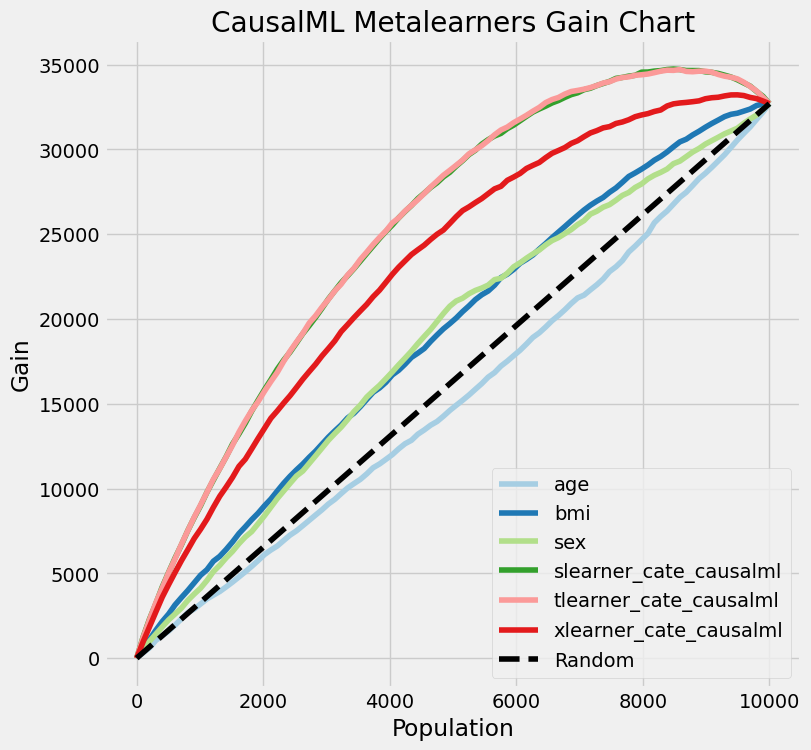

In [11]:
# 使用CausalML的工具进行模型评估
plot_gain(df, outcome_col='outcome', treatment_col='treatment')
plt.title('CausalML Metalearners Gain Chart')
plt.show()

In [11]:
from econml.metalearners import SLearner, TLearner, XLearner
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

In [12]:
# EconML的API更接近scikit-learn
# 1. S-Learner实现
print("\n--- EconML S-Learner ---")
slearner_econ = SLearner(overall_model=RandomForestRegressor(n_estimators=100, random_state=42))
slearner_econ.fit(Y=outcome, T=treatment, X=X)
slearner_cate_econ = slearner_econ.effect(X)
df['slearner_cate_econml'] = slearner_cate_econ
df


--- EconML S-Learner ---


/root/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,age,bmi,sex,treatment,outcome,slearner_cate_causalml,tlearner_cate_causalml,xlearner_cate_causalml,slearner_cate_econml
0,48.727006,22.048553,0,0,4.549021,-0.265474,-0.794183,-1.530022,-0.203010
1,77.535715,23.499256,0,1,14.477370,4.079010,3.716235,1.704245,4.102334
2,66.599697,29.555276,0,0,7.735355,1.456587,1.649411,1.836407,1.452354
3,59.932924,23.304507,0,1,5.939146,0.515412,0.568381,1.027229,0.605791
4,37.800932,32.450537,1,0,4.815693,0.982102,0.812490,1.518545,0.889000
...,...,...,...,...,...,...,...,...,...
9995,72.882799,27.887503,1,0,2.994241,6.533094,6.466014,6.008768,6.573605
9996,74.875442,31.169580,0,1,10.686892,4.609731,4.270597,2.947741,4.368721
9997,77.335396,31.978072,1,1,13.164395,6.103733,5.157341,5.966728,6.156519
9998,49.874400,25.210681,0,1,3.996664,0.838999,0.923956,1.110228,0.940376


In [13]:
# 2. T-Learner实现
print("--- EconML T-Learner ---")
tlearner_econ = TLearner(models=RandomForestRegressor(n_estimators=100, random_state=42))
tlearner_econ.fit(Y=outcome, T=treatment, X=X)
tlearner_cate_econ = tlearner_econ.effect(X)
df['tlearner_cate_econml'] = tlearner_cate_econ
df

--- EconML T-Learner ---


/root/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,age,bmi,sex,treatment,outcome,slearner_cate_causalml,tlearner_cate_causalml,xlearner_cate_causalml,slearner_cate_econml,tlearner_cate_econml
0,48.727006,22.048553,0,0,4.549021,-0.265474,-0.794183,-1.530022,-0.203010,-0.794183
1,77.535715,23.499256,0,1,14.477370,4.079010,3.716235,1.704245,4.102334,3.716235
2,66.599697,29.555276,0,0,7.735355,1.456587,1.649411,1.836407,1.452354,1.649411
3,59.932924,23.304507,0,1,5.939146,0.515412,0.568381,1.027229,0.605791,0.568381
4,37.800932,32.450537,1,0,4.815693,0.982102,0.812490,1.518545,0.889000,0.812490
...,...,...,...,...,...,...,...,...,...,...
9995,72.882799,27.887503,1,0,2.994241,6.533094,6.466014,6.008768,6.573605,6.466014
9996,74.875442,31.169580,0,1,10.686892,4.609731,4.270597,2.947741,4.368721,4.270597
9997,77.335396,31.978072,1,1,13.164395,6.103733,5.157341,5.966728,6.156519,5.157341
9998,49.874400,25.210681,0,1,3.996664,0.838999,0.923956,1.110228,0.940376,0.923956


In [ ]:
# 3. X-Learner实现
# X-Learner需要一个倾向得分模型
print("--- EconML X-Learner ---")
xlearner_econ = XLearner(models=RandomForestRegressor(n_estimators=100, random_state=42),
                         propensity_model=LogisticRegression())
xlearner_econ.fit(Y=outcome, T=treatment, X=X)
xlearner_cate_econ = xlearner_econ.effect(X)
df['xlearner_cate_econml'] = xlearner_cate_econ

df

--- EconML X-Learner ---


In [ ]:
from econml.dml import CausalForestDML # DML方法，与R-Learner思想一致
from econml.dr import DRLearner
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [17]:
# # 1. R-Learner (以DML形式实现)
# print("\n--- EconML R-Learner (CausalForestDML) ---")
# # CausalForestDML需要模型来估计结果(model_y)和处理(model_t)
# # 这对应R-Learner中的 m(x) 和 e(x)
# rlearner_econ = CausalForestDML(
#                                 random_state=42)
# rlearner_econ.fit(Y=outcome, T=treatment, X=X)
# rlearner_cate_econ = rlearner_econ.effect(X)
# df['rlearner_cate_econml'] = rlearner_cate_econ
# df

In [ ]:
# 2. DR-Learner
print("--- EconML DR-Learner ---")
drlearner_econ = DRLearner(model_propensity=LogisticRegression(),
                           model_regression=RandomForestRegressor(n_estimators=100, random_state=42),
                           random_state=42)
drlearner_econ.fit(Y=outcome, T=treatment, X=X)
drlearner_cate_econ = drlearner_econ.effect(X)
df['drlearner_cate_econml'] = drlearner_cate_econ

df

In [ ]:
df['true_cate'] = true_cate

cate_cols = [col for col in df.columns if '_cate' in col]
for col in cate_cols:
    rmse = np.sqrt(np.mean((df[col] - df['true_cate'])**2))
    print(f"RMSE for {col}: {rmse:.4f}")


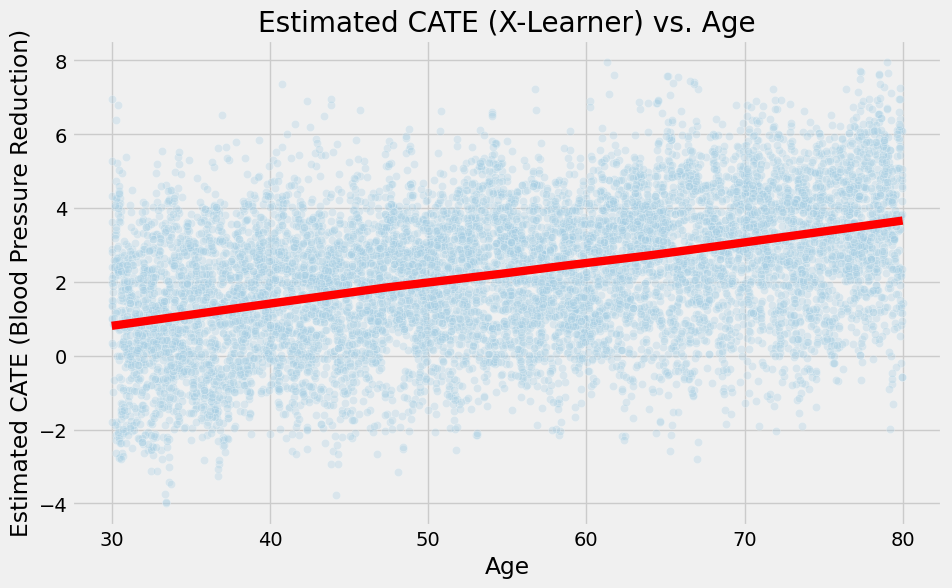

In [20]:
# 以X-Learner为例，分析CATE与年龄的关系
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['age'], y=df['xlearner_cate_econml'], alpha=0.3)
# 添加一条平滑曲线
sns.regplot(x=df['age'], y=df['xlearner_cate_econml'], scatter=False, lowess=True, line_kws={'color': 'red'})
plt.title('Estimated CATE (X-Learner) vs. Age')
plt.xlabel('Age')
plt.ylabel('Estimated CATE (Blood Pressure Reduction)')
plt.grid(True)
plt.show()

In [21]:
df_sorted = df.sort_values(by='xlearner_cate_econml', ascending=False)
top_10_percent = df_sorted.head(int(n_samples * 0.1))

print("\n特征分析：最受益的前10%患者 vs. 总体患者")
print(top_10_percent[['age', 'bmi', 'sex']].describe())
print("\n总体患者特征：")
print(df[['age', 'bmi', 'sex']].describe())


特征分析：最受益的前10%患者 vs. 总体患者
               age          bmi          sex
count  1000.000000  1000.000000  1000.000000
mean     66.083464    31.128515     0.896000
std      11.748426     3.707114     0.305413
min      30.001536    19.371853     0.000000
25%      60.819628    28.617474     1.000000
50%      68.968435    30.887328     1.000000
75%      75.727880    33.702881     1.000000
max      79.975259    41.511073     1.000000

总体患者特征：
                age           bmi           sex
count  10000.000000  10000.000000  10000.000000
mean      54.707978     28.049422      0.496000
std       14.381506      3.999098      0.500009
min       30.000582     12.310399      0.000000
25%       42.316443     25.366378      0.000000
50%       54.626431     28.067227      0.000000
75%       67.000317     30.729506      1.000000
max       79.985884     45.916337      1.000000


In [22]:
df

,age,bmi,sex,treatment,outcome,slearner_cate_causalml,tlearner_cate_causalml,xlearner_cate_causalml,slearner_cate_econml,tlearner_cate_econml,xlearner_cate_econml,drlearner_cate_econml,true_cate
0,48.727006,22.048553,0,0,4.549021,-0.265474,-0.794183,-1.530022,-0.203010,-0.794183,-1.520282,-0.349487,-0.253939
1,77.535715,23.499256,0,1,14.477370,4.079010,3.716235,1.704245,4.102334,3.716235,1.736861,1.542560,1.476637
2,66.599697,29.555276,0,0,7.735355,1.456587,1.649411,1.836407,1.452354,1.649411,1.822351,2.258586,2.141040
3,59.932924,23.304507,0,1,5.939146,0.515412,0.568381,1.027229,0.605791,0.568381,1.017067,0.536629,0.557548
4,37.800932,32.450537,1,0,4.815693,0.982102,0.812490,1.518545,0.889000,0.812490,1.512147,3.206421,3.280154
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,72.882799,27.887503,1,0,2.994241,6.533094,6.466014,6.008768,6.573605,6.466014,6.057440,4.136356,4.121641
9996,74.875442,31.169580,0,1,10.686892,4.609731,4.270597,2.947741,4.368721,4.270597,2.993356,3.062087,2.877688
9997,77.335396,31.978072,1,1,13.164395,6.103733,5.157341,5.966728,6.156519,5.157341,5.961555,5.268138,5.162384
9998,49.874400,25.210681,0,1,3.996664,0.838999,0.923956,1.110228,0.940376,0.923956,1.081623,0.399797,0.435856


In [23]:
df.to_csv("metalearner_data.csv")

SyntaxError: invalid syntax (791285630.py, line 1)